Need to show two solutions are unstable since they do not occur in simulations.

In [1]:
from functions import Plasma, Spectral, polyeig
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from tqdm import tqdm
from scipy.optimize import curve_fit

W = lambda z,k: np.real(lambertw(z,k=k)) # I only need the real parts

In [19]:
def velocity_profile(M, Mm, x, constant_velocity=False,acclerting=True):
    if constant_velocity:
        v = Mm*np.ones_like(x) # constant v=0.1
        return v

    if Mm < 1:
        v = M(x, Mm=Mm, k=0) # subsonic velocity profile, M_m = 0.1
    elif Mm == 1:
        if method == "FD":
            if acclerting:
                v = np.concatenate([M(x[x<0], Mm=1, k=0), [1], M(x[x>0], Mm=1, k=-1)]) # accelerating velocity profile
            else:
                v = np.concatenate([M(x[x<0], Mm=1, k=-1), [1], M(x[x>0], Mm=1, k=0)]) # decelerating velocity profile
        elif method == "CH":
            if acclerting:
                v = np.concatenate([M(x[x>0], Mm=1, k=-1), M(x[x<0], Mm=1, k=0)]) # accelerating velocity profile
            else:
                v = np.concatenate([M(x[x>0], Mm=1, k=0), M(x[x<0], Mm=1, k=-1)]) # decelerating velocity profile
    else:
        v = M(x, Mm=Mm, k=-1) # supersonic velocity profile
    return v

def compute(plasma, spectral):
    """
    Solve polynomial eigenvalue problem
    """
    # differentiation matrices
    x = spectral.x
    D1 = spectral.D1
    D2 = spectral.D2
    I = np.eye(*D1.shape)
    v0 = plasma.v

    # matrices for polynomial eigenvalue problem
    A2 = I
    A1 = 2j*(np.diag(v0)@D1 + np.diag(D1@v0))
    A0 = np.diag(1-v0**2)@D2 \
        - np.diag((3*v0 + 1/v0)*(D1@v0))@D1 \
        - np.diag((1-1/v0**2)*(D1@v0)**2) \
        - np.diag((v0+1/v0)*(D2@v0))

    # A2 = I
    # A1 = 1j*2*np.diag(v0)@D1
    # A0 = np.diag(1-v0**2)@D2 

    # remove boundaries because derivatives behave bad there
    A2 = A2[1:-1,1:-1]
    A1 = A1[1:-1,1:-1]
    A0 = A0[1:-1,1:-1]

    # eigenvectors, eigenvalues
    V, e = polyeig(-A0, -A1, -A2)
    #omega = -1j*e
    omega = e
    
    # Q-function and P-function
    Q = -(1-1/v0**2)*(D1@v0)**2 - (v0+1/v0)*(D2@v0)
    P = -(D1@v0)*(3*v0+1/v0)
    Q = Q[1:-1] # remove boundaries since derivatives behave bad
    P = P[1:-1]

    # Dirichlet boundary condition
    V = np.pad(V, ((1,1),(0,0)), 'constant', constant_values=0)
    Q = np.pad(Q, (1,1), 'constant', constant_values=0)
    P = np.pad(P, (1,1), 'constant', constant_values=0)


    results = {"V":V, "omega":omega, "Q":Q, "P":P}
    return results


mean = lambda y_vals: np.trapz(y_vals,spectral.x)/(spectral.x.max()-spectral.x.min())

def plotting(plasma, spectral, results):
    V = results["V"]
    omega = results["omega"]
    Q = results["Q"]
    P = results["P"]

    # velocity profile
    plt.figure()
    plt.plot(spectral.x, plasma.v)
    plt.title(f"Velocity profile ($M_m={Mm}$)")
    plt.xlabel("$z$")
    plt.ylabel("$v$");

    

    # eigenvectors
    plt.figure()
    # selection = (np.abs(np.real(omega))<5) & (np.abs(np.imag(omega))<30) 
    selection = (np.abs(np.real(omega))<10) & (np.abs(np.imag(omega))>10) 
    omega_ = omega[selection]
    V_ = V[:, selection]

    ind = np.argsort(np.abs(np.imag(omega_)))
    omega_ = omega_[ind]
    V_ = V_[:,ind]

    size = 5 if omega_.size > 5 else omega_.size
    for i in range(size):
        lines = plt.plot(spectral.x, np.real(V_[:,i]), label=f"$\omega={omega_[i]}$")
        plt.plot(spectral.x, np.imag(V_[:,i]), '--', color=lines[0]._color)
    plt.xlabel("x")
    plt.ylabel("$\\tilde{v}$")
    plt.title(f"Eigenvectors ($M_m={Mm}$)")
    plt.legend();

    # P and Q functions
    # this test is not so accurate since |v_tilde|^2 is not constant for most cases
    plt.figure()
    f = Q-0.5*spectral.D1@P
    f[[0,-1]] = 1
    f_mean = np.trapz(f,spectral.x)/2 # remove the boundaries to improve accuracy
    plt.plot(spectral.x, Q, label="$Q$")
    plt.plot(spectral.x, P, label="$P$")
    line = plt.plot(spectral.x, f, label="$Q-P'/2$")
    #plt.fill_between(spectral.x,0,f,color=line[0]._color)
    plt.xlabel("z")
    plt.text(-1,1,"$\\langle Q-0.5P'\\rangle = $" + str(round(f_mean,10)), fontdict={"fontsize":16})
    #plt.text(-1,6,"$-0.25\\langle \\partial_zv_0 \\rangle = $" + str(round(-0.25*g_mean,10)), fontdict={"fontsize":16})
    plt.title(f"$M_m={Mm}$")
    plt.legend();
    

def stability_condition(plasma, spectral, results, omega_r, v_tilde):
    """
    Full instability condition from real part

    check stability condition for a specific omega and a specific v
    """
    P, Q = results["P"], results["Q"]

    x, D1 = spectral.x, spectral.D1
    v0 = plasma.v

    v_sqr = np.real(v_tilde*v_tilde.conj())

    pdv_v = D1@v_tilde
    pdv_v[[0,-1]] = 0

    pdv_v0 = D1@v0
    pdv_v0[[0,-1]] = 0

    pdv_v_sqr = D1@v_sqr
    pdv_v_sqr[[0,-1]] = 0

    pdv_P = D1@P
    pdv_P[[0,-1]] = 0

    # coefficients of quadratic equation about gamma
    a = -mean(v_sqr)
    b = -mean(pdv_v0*v_sqr)
    c = omega_r**2*mean(v_sqr) \
        - 2*omega_r*mean(v0*np.imag(v_tilde.conj()*pdv_v)) \
        - mean((1-v0**2)*np.real(pdv_v.conj()*pdv_v)) \
        + mean((Q-0.5*pdv_P)*v_sqr)

    discriminant = b**2 - 4*a*c
    # if discriminant > 0:
    #     print(f"discriminant={discriminant:0.5f}>0, unstable")
    # elif discriminant < 0:
    #     print(f"discriminant={discriminant:0.5f}<0, stable")
    return discriminant

In [20]:
# domain information
N = 101 # 200 cells
domain = "symmetric"
method = "FD"
spectral = Spectral(N,domain,method)

# magnetic field, B, and velocity profile, M
B0 = 1
R = 0.00
Bm = 1+R
Delta = 0.1/0.3
B = lambda z: B0*(1+R*np.exp(-(z/Delta)**2))

# k=-1: supersonic branch
# k=0: subsonic branch
M = lambda z, Mm, k: np.sqrt( -W(-Mm**2 * (B(z)/Bm)**2 * np.exp(-Mm**2), k=k) )

E0 = 1 # unit: V/m
B0 = 1 # unit: G
Ln = -0.3 # density gradient
LE = 0.004 # shear scale
Lb = 0 # magnetic field gradient
n = 1e16 # density m^{-3}
Te = 10 # electron temperature in eV
Ti = 0 # ion temperature in eV
fluid = 'Ar' # fluid type
plasma = Plasma(n,Te,Ti,Ln,Lb,E0,B0,fluid)

x = spectral.x
Mm = 1.5
acclerting = False
constant_velocity = True
plasma.v = velocity_profile(M,Mm,x,constant_velocity,acclerting)

results = compute(plasma, spectral)

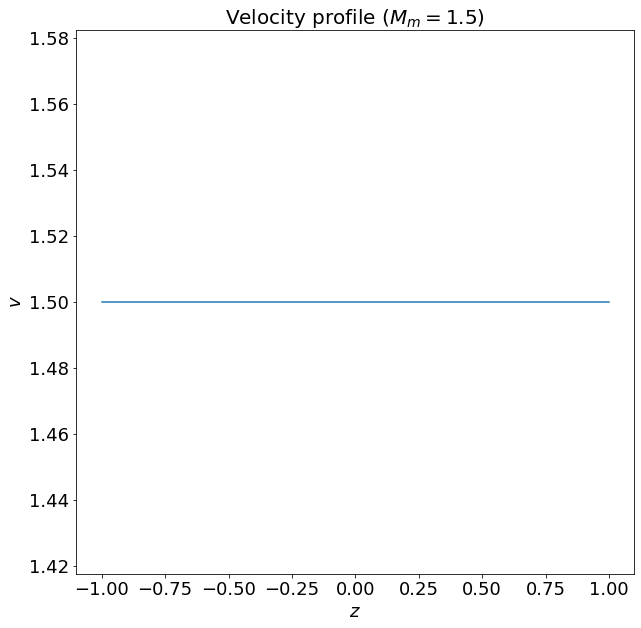

In [21]:
# velocity profile
V = results["V"]
omega = results["omega"]
Q = results["Q"]
P = results["P"]

plt.figure()
plt.plot(spectral.x, plasma.v)
plt.title(f"Velocity profile ($M_m={Mm}$)")
plt.xlabel("$z$")
plt.ylabel("$v$");

In [5]:
# remove bad eigenfunctions
from scipy.interpolate import interp1d
xx = np.linspace(-1,1,5*N)
f = interp1d(spectral.x, V.T)
zeros = np.isclose(f(xx).T, 0, atol=1e-3).sum(axis=0)
omega = omega[zeros<int(spectral.N/10)]
V = V[:,zeros<int(spectral.N/10)]

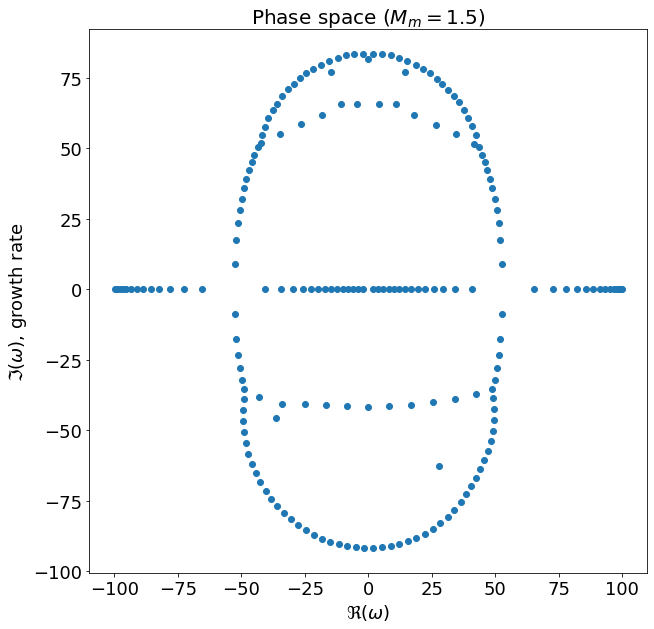

In [22]:
# phase space
plt.figure()
selection = (np.abs(np.real(omega))<10) & (np.abs(np.imag(omega))<10)
omega_ = omega#[selection]

plt.plot(np.real(omega_), np.imag(omega_), 'o')
#plt.plot(np.real(omega), np.imag(omega), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$, growth rate")
if (Mm == 1) & (acclerting):
    plt.title(f"Phase space ($M_m={Mm}$, accelerating)");
elif (Mm == 1) & (not acclerting):
    plt.title(f"Phase space ($M_m={Mm}$, decelerating)");
else:
    plt.title(f"Phase space ($M_m={Mm}$)");

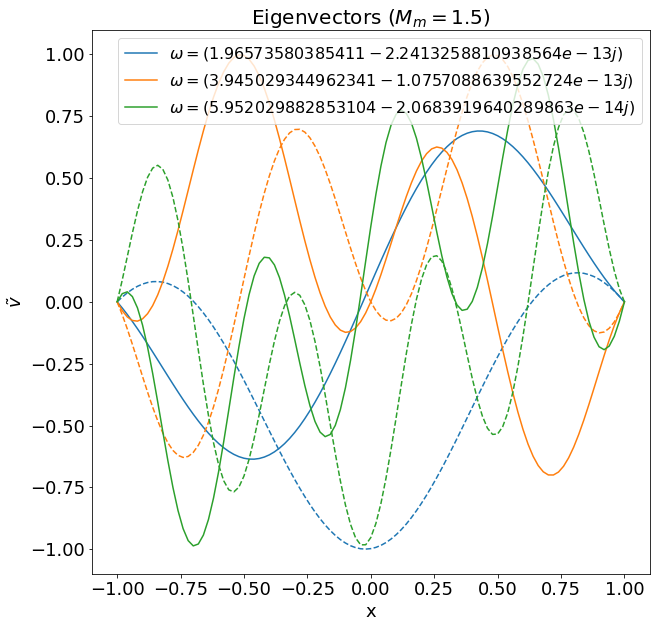

In [10]:
# eigenvectors
plt.figure()
#selection = (np.abs(np.real(omega))<10) & (np.abs(np.imag(omega))<10) 
selection = np.real(omega) >= 0
omega_ = omega[selection]
V_ = V[:, selection]

zeros = np.isclose(V_, 0, atol=1e-3).sum(axis=0)
omega_ = omega_[zeros<int(spectral.N/10)]
V_ = V_[:,zeros<int(spectral.N/10)]

ind = np.argsort(np.abs(np.real(omega_)))
omega_ = omega_[ind]
V_ = V_[:,ind]

size = 3 if omega_.size > 3 else omega_.size
for i in range(size):
    lines = plt.plot(spectral.x, np.real(V_[:,i]), label=f"$\omega={omega_[i]}$")
    plt.plot(spectral.x, np.imag(V_[:,i]), '--', color=lines[0]._color)
plt.xlabel("x")
plt.ylabel("$\\tilde{v}$")
plt.title(f"Eigenvectors ($M_m={Mm}$)")
plt.legend();

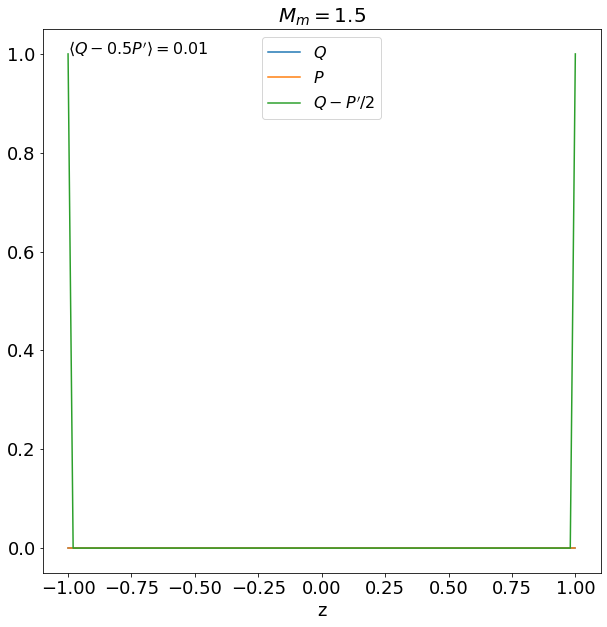

In [42]:
# P and Q functions
# this test is not so accurate since |v_tilde|^2 is not constant for most cases
plt.figure()
f = Q-0.5*spectral.D1@P
f[[0,-1]] = 1
f_mean = np.trapz(f,spectral.x)/2 # remove the boundaries to improve accuracy
plt.plot(spectral.x, Q, label="$Q$")
plt.plot(spectral.x, P, label="$P$")
line = plt.plot(spectral.x, f, label="$Q-P'/2$")
#plt.fill_between(spectral.x,0,f,color=line[0]._color)
plt.xlabel("z")
plt.text(-1,1,"$\\langle Q-0.5P'\\rangle = $" + str(round(f_mean,10)), fontdict={"fontsize":16})
#plt.text(-1,6,"$-0.25\\langle \\partial_zv_0 \\rangle = $" + str(round(-0.25*g_mean,10)), fontdict={"fontsize":16})
plt.title(f"$M_m={Mm}$")
plt.legend();

In [43]:
V,omega,P,Q = results["V"], results["omega"], results["P"], results["Q"]
selection = (np.abs(np.imag(omega))<1) & (np.real(omega)>=0)
omega_ = omega[selection]
V_ = V[:,selection]
ind = np.argsort(np.real(omega_))
omega_ = omega_[ind]
V_ = V_[:,ind]

In [44]:
omega_[0]

(1.9657358038542625-3.006956341896625e-13j)

In [45]:
v_tilde = V_[:,0]
omega_r = np.real(omega_[0])

stability_condition(plasma,spectral, results, omega_r, v_tilde)

-0.07641408644069105

In [ ]:
# make video for phase space when Mm approaches 1 from subsonic side
for frame, Mm in enumerate(tqdm(np.arange(0.50,1.0,0.02))):
    plasma.v = M(x, Mm=Mm, k=0)
    V,omega, Q,P = compute(plasma, spectral)

    plt.figure()
    plt.plot(spectral.x, Q, color='k')
    plt.fill_between(spectral.x,0,Q)
    plt.xlabel("z")
    plt.ylabel("Q")
    plt.title("$\\int_{-1}^{1} Q =$" + str(Q_int))
    plt.savefig(f"video/Q-function/supersonic/{frame}.png")
    plt.close();

    # plt.figure()
    # plt.plot(np.real(Omega), np.imag(Omega), 'o')
    # plt.xlabel("$\Re(\Omega)$")
    # plt.ylabel("$\Im(\Omega)$")
    # plt.title(f"Phase space ($M_m={Mm:.4f}$)")
    # plt.savefig(f"video/supersonic/phase-space-{frame}.png")
    # plt.close();

/home/hunt/plasma-physics/usask-project/magnetic-nozzle/functions.py:178: RuntimeWarning: invalid value encountered in true_divide
  X /= np.tile(np.max(np.abs(X),axis=0), (n,1))


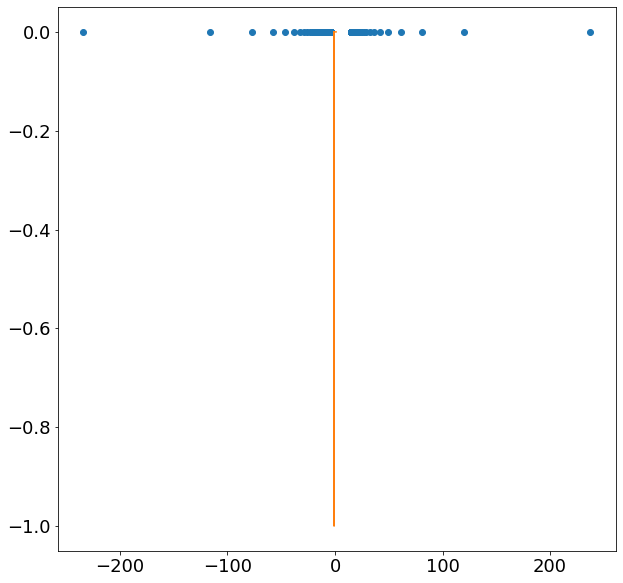

In [ ]:
# compute k
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2
I = np.eye(*D1.shape)
v0 = plasma.v
omega = 10j

A0 = omega**2*I
A1 = 1j*2*omega*np.diag(v0)
A2 = np.diag(1-v0**2) # The sign of this matrix affects the instability ??

# remove boundaries because derivatives behave bad there
A2 = A2[1:-1,1:-1]
A1 = A1[1:-1,1:-1]
A0 = A0[1:-1,1:-1]

V, e = polyeig(A0,A1,A2)

V = np.pad(V, ((1,1),(0,0)), 'constant', constant_values=0)

plt.plot(np.real(e), np.imag(e),'o')
plt.plot(x, np.real(V[:,10]))